In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dager234","key":"6338f24975e7a589a85f796e2187bc38"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [03:02<00:00, 24.3MB/s]
100% 3.79G/3.79G [03:02<00:00, 22.3MB/s]


In [6]:
!unzip deepglobe-road-extraction-dataset


Streaming output truncated to the last 5000 lines.
  inflating: train/723199_sat.jpg    
  inflating: train/723226_mask.png   
  inflating: train/723226_sat.jpg    
  inflating: train/723436_mask.png   
  inflating: train/723436_sat.jpg    
  inflating: train/723483_mask.png   
  inflating: train/723483_sat.jpg    
  inflating: train/723622_mask.png   
  inflating: train/723622_sat.jpg    
  inflating: train/723722_mask.png   
  inflating: train/723722_sat.jpg    
  inflating: train/723970_mask.png   
  inflating: train/723970_sat.jpg    
  inflating: train/723990_mask.png   
  inflating: train/723990_sat.jpg    
  inflating: train/724095_mask.png   
  inflating: train/724095_sat.jpg    
  inflating: train/724431_mask.png   
  inflating: train/724431_sat.jpg    
  inflating: train/724485_mask.png   
  inflating: train/724485_sat.jpg    
  inflating: train/724705_mask.png   
  inflating: train/724705_sat.jpg    
  inflating: train/724870_mask.png   
  inflating: train/724870_sat.jpg    

In [7]:
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [8]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }


def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [9]:
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [10]:
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts= 0.1)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [11]:
framObjTrain = LoadData( framObjTrain, imgPath = 'train', maskPath = 'train' , shape = 128)

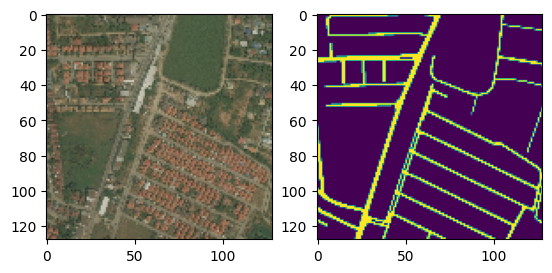

In [12]:
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][10])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][10])
plt.show()

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [14]:
history = unet.fit(x=np.array(framObjTrain['img']), y=np.array(framObjTrain['mask']), epochs = 10, verbose = 2,validation_split=0.1, callbacks=[callback])

Epoch 1/10
176/176 [==============================] - 50s 140ms/step - loss: 0.2287 - accuracy: 0.9464 - val_loss: 0.2898 - val_accuracy: 0.9531
Epoch 2/10
176/176 [==============================] - 22s 125ms/step - loss: 0.1529 - accuracy: 0.9534 - val_loss: 0.1547 - val_accuracy: 0.9531
Epoch 3/10
176/176 [==============================] - 23s 129ms/step - loss: 0.1347 - accuracy: 0.9540 - val_loss: 0.1421 - val_accuracy: 0.9535
Epoch 4/10
176/176 [==============================] - 23s 129ms/step - loss: 0.1239 - accuracy: 0.9550 - val_loss: 0.1251 - val_accuracy: 0.9549
Epoch 5/10
176/176 [==============================] - 22s 127ms/step - loss: 0.1179 - accuracy: 0.9560 - val_loss: 0.1973 - val_accuracy: 0.9534
Epoch 6/10
176/176 [==============================] - 22s 127ms/step - loss: 0.1124 - accuracy: 0.9571 - val_loss: 0.1189 - val_accuracy: 0.9559
Epoch 7/10
176/176 [==============================] - 23s 128ms/step - loss: 0.1074 - accuracy: 0.9582 - val_loss: 0.1109 - val_ac

In [15]:
unet.save('MapSegmentationGenerator.h5')

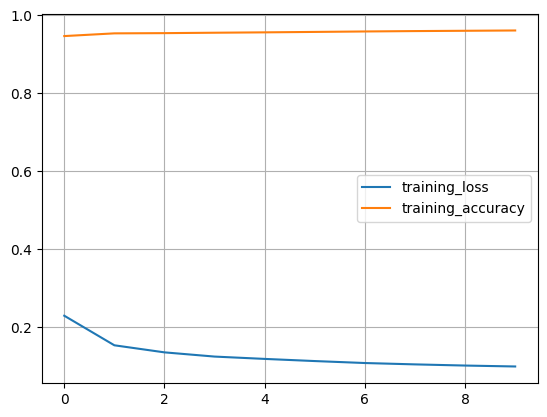

In [16]:
plt.plot(history.history['loss'], label = 'training_loss')
plt.plot(history.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

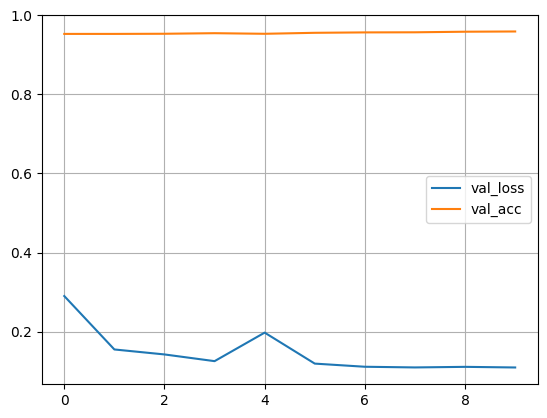

In [19]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid(True)

In [20]:
def predict16 (valMap, model, shape = 128):
    ## getting and proccessing val data
    img = valMap['img'][0:16]
    mask = valMap['mask'][0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')

In [21]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)


1/1 [==============================] - 1s 1s/step


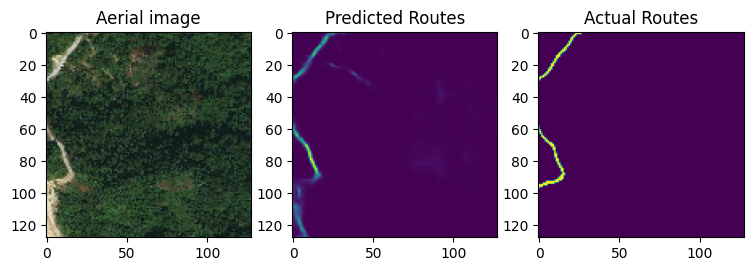

In [22]:
Plotter(actuals[12], sixteenPrediction[12][:,:,0], masks[12])

In [23]:
framObjTest = {'img' : [],
           'mask' : []
          }

def LoadDatatest( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames=[]
    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)
    
    imgAddr = imgPath + '/'
    
    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg') 
            #mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')
            
        except:
            continue
        img = cv2.resize(img, (shape, shape))
        #mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        #frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0
        
    return frameObj

In [24]:
framObjTest = LoadDatatest( framObjTest, imgPath = 'test', shape = 128)


In [25]:
jj=unet.predict(np.array(framObjTest['img']))

35/35 [==============================] - 2s 46ms/step


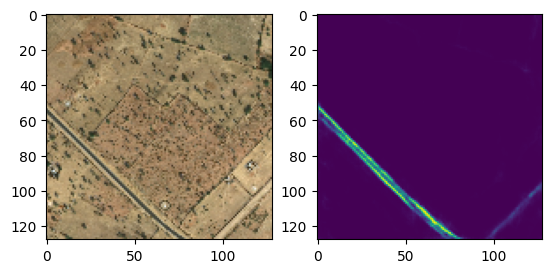

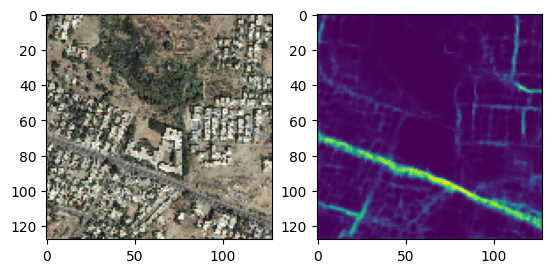

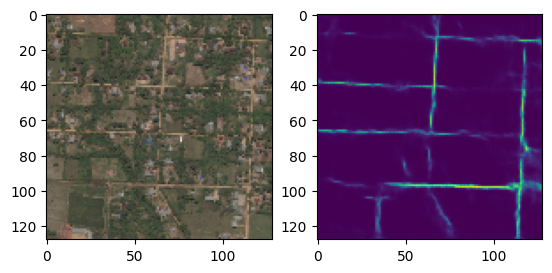

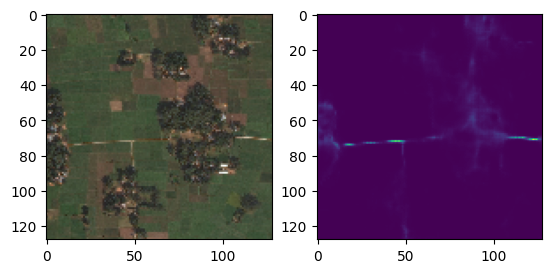

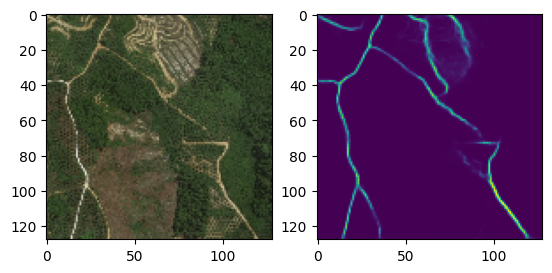

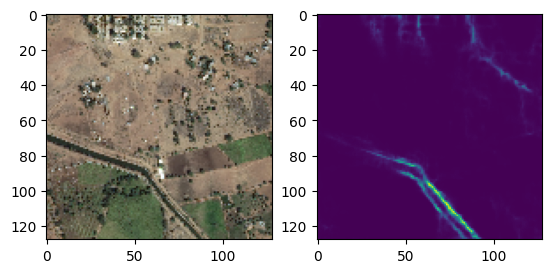

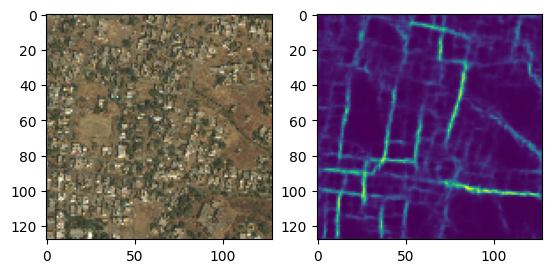

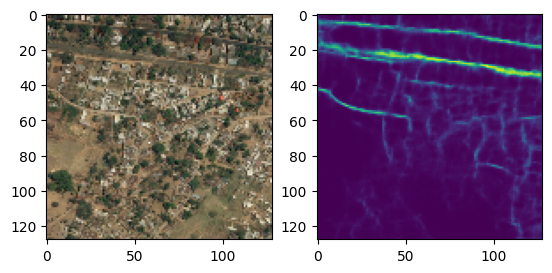

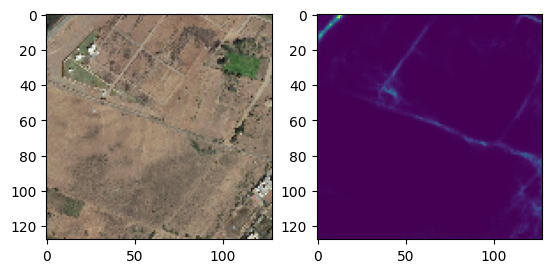

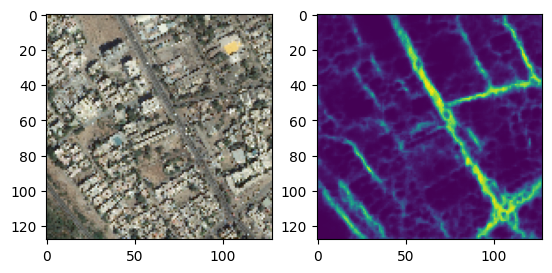

In [27]:
for i in range(10):
    plt.subplot(1,2,1)
    plt.imshow(framObjTest['img'][i])
    plt.subplot(1,2,2)
    plt.imshow(jj[i])
    plt.show()

In [1]:
%pwd

'C:\\Users\\Acer\\Downloads'